## Algorithmic Market Making - Theoretical Test

### Here is the code for theoretical tests on 2 models and comparison with the naive trading strategy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Model 1 in Dealing with the Inventory Risk: A solution to the market making problem.

In [2]:
# Define function for model 1

def simple1(k, gamma, sigma, A, s, q0, x0, T, N):
    
    alpha = 0.5*k*gamma*sigma**2
    eta = A*(1 + gamma/k)**(-(1 + k/gamma))
    
    dt = T/N
    delta_a_list = np.zeros(N+1)
    delta_b_list = np.zeros(N+1)
    q_list = np.zeros(N+1)
    x_list = np.zeros(N+1)
    q_list[0] = q0
    x_list[0] = x0
    delta_b = 1/gamma*np.log(1 + gamma/k) + 1/(2*k)*(alpha/eta)**0.5*(2*q_list[0] + 1)
    delta_a = 1/gamma*np.log(1 + gamma/k) - 1/(2*k)*(alpha/eta)**0.5*(2*q_list[0] - 1)
    delta_a_list[0] = delta_a
    delta_b_list[0] = delta_b
    
    for i in range(N):
        lab_a = A*np.exp(-k*delta_a)
        lab_b = A*np.exp(-k*delta_b)

        na = np.random.poisson(lam = lab_a*dt)
        nb = np.random.poisson(lam = lab_b*dt)
        
        q_list[i+1] = q_list[i] + nb - na
        x_list[i+1] = x_list[i] + (s[i] + delta_a)*na - (s[i] - delta_b)*nb
        #print('na =', na, 'nb =', nb, 'q =', q_list[i])
        
        delta_b = 1/gamma*np.log(1 + gamma/k) + 1/(2*k)*(alpha/eta)**0.5*(2*q_list[i+1] + 1)
        delta_a = 1/gamma*np.log(1 + gamma/k) - 1/(2*k)*(alpha/eta)**0.5*(2*q_list[i+1] - 1)
        
        delta_a_list[i+1] = delta_a
        delta_b_list[i+1] = delta_b
        
    pol = x_list + q_list*s
    return pol, delta_a_list, delta_b_list, q_list, x_list

In [3]:
# Define function to generate arithmetic brownian motion for stock price

def bm(s0, T, N, sigma, mu = 0):
    dt = T/N
    s = np.zeros(N+1)
    s[0] = s0
    for i in range(N):
        s[i+1] = s[i] + mu*dt + np.random.normal()*sigma*(dt)**0.5
    
    return s

In [4]:
k = 0.3*100
gamma = 0.01*100
sigma = 0.4*0.01
A = 0.9
q0 = 0
x0 = 0
T = 600
N = 600
s0 = 100

In [5]:
s = bm(s0, T, N, sigma)
pol, a, b, q, x = simple1(k, gamma, sigma, A, s, q0, x0, T, N)
psi = a + b
dp = pol[1:601] - pol[0:600]
horizon = np.array(range(N+1))*T/N

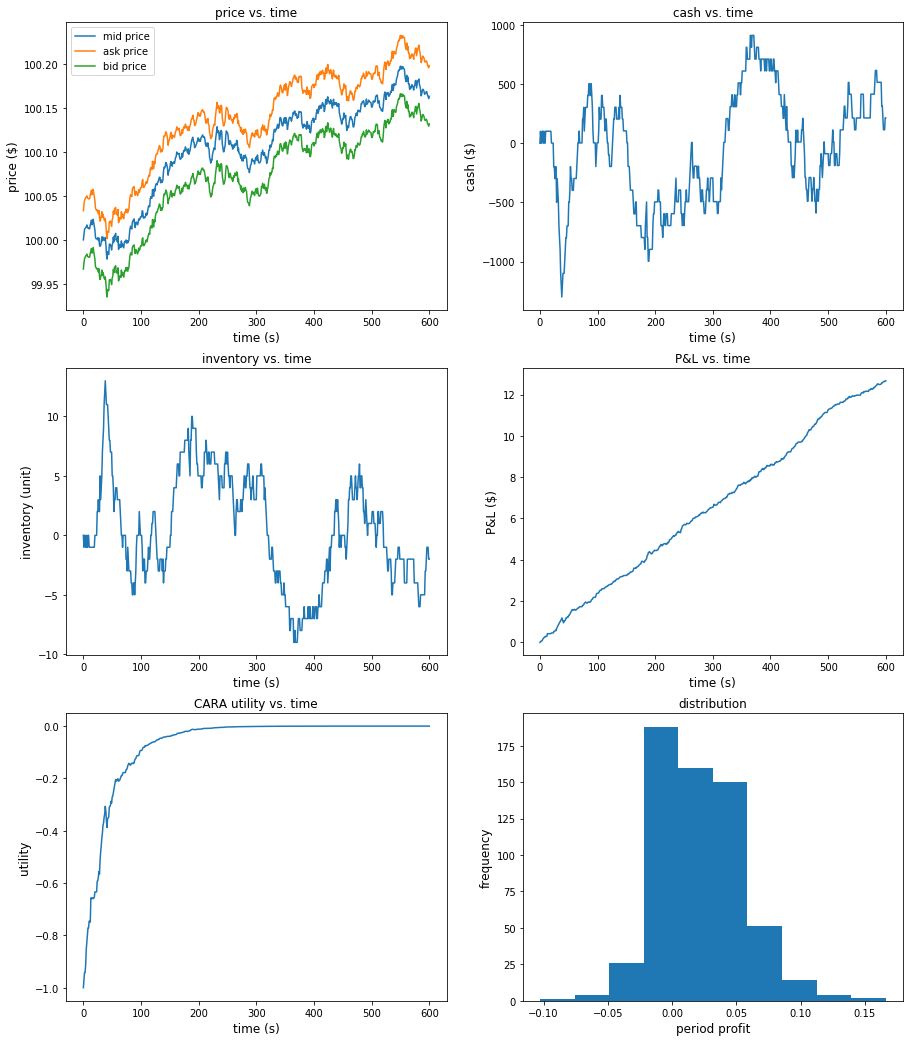

In [16]:
plt.figure(figsize = (15,18))

plt.subplot(3,2,1)
plt.plot(horizon, s, label = 'mid price')
plt.plot(horizon, s + a, label = 'ask price')
plt.plot(horizon, s - b, label = 'bid price')
plt.legend(loc = 'upper left')
plt.title('price vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('price ($)', fontsize=12)

plt.subplot(3,2,2)
plt.plot(horizon, x)
plt.title('cash vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('cash ($)', fontsize=12)

plt.subplot(3,2,3)
plt.plot(horizon, q)
plt.title('inventory vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('inventory (unit)', fontsize=12)

plt.subplot(3,2,4)
plt.plot(horizon, pol)
plt.title('P&L vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('P&L ($)', fontsize=12)

plt.subplot(3,2,5)
plt.plot(horizon, -np.exp(-gamma*pol))
plt.title('CARA utility vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('utility', fontsize=12)

plt.subplot(3,2,6)
plt.hist(dp)
plt.title('distribution', fontsize=12)
plt.xlabel('period profit', fontsize=12)
plt.ylabel('frequency', fontsize=12)


plt.show()

#### Model 2 in High frequency trading in a limit order book.

In [18]:
def simple2(k, gamma, sigma, A, s, q0, x0, T, N):

    dt = T/N
    delta_a_list = np.zeros(N+1)
    delta_b_list = np.zeros(N+1)
    q_list = np.zeros(N+1)
    x_list = np.zeros(N+1)
    q_list[0] = q0
    x_list[0] = x0
    r = s[0] - q0*gamma*sigma**2*T
    spread = gamma*sigma**2*T + 2/gamma*np.log(1 + gamma/k)
    delta_b = s[0] - (r - spread/2)
    delta_a = r + spread/2 -s[0]
    delta_a_list[0] = delta_a
    delta_b_list[0] = delta_b
    
    for i in range(N):
        lab_a = A*np.exp(-k*delta_a)
        lab_b = A*np.exp(-k*delta_b)

        na = np.random.poisson(lam = lab_a*dt)
        nb = np.random.poisson(lam = lab_b*dt)
        
        q_list[i+1] = q_list[i] + nb - na
        x_list[i+1] = x_list[i] + (s[i] + delta_a)*na - (s[i] - delta_b)*nb
        #print('na =', na, 'nb =', nb, 'q =', q_list[i])
        
        r = s[i+1] - q_list[i+1]*gamma*sigma**2*(N - i - 1)*dt
        
        spread = gamma*sigma**2*(N - i - 1)*dt + 2/gamma*np.log(1 + gamma/k)
        delta_b = s[i+1] - (r - spread/2)
        delta_a = r + spread/2 -s[i+1]
        
        delta_a_list[i+1] = delta_a
        delta_b_list[i+1] = delta_b
        
    pol = x_list + q_list*s
    return pol, delta_a_list, delta_b_list, q_list, x_list

In [19]:
k = 0.3*100
gamma = 0.01*100
sigma = 0.4*0.01
A = 0.9
q0 = 0
x0 = 0
T = 600
N = 600
s0 = 100

In [20]:
pol, a, b, q, x = simple2(k, gamma, sigma, A, s, q0, x0, T, N)
psi = a + b
dp = pol[1:601] - pol[0:600]
horizon = np.array(range(N+1))*T/N

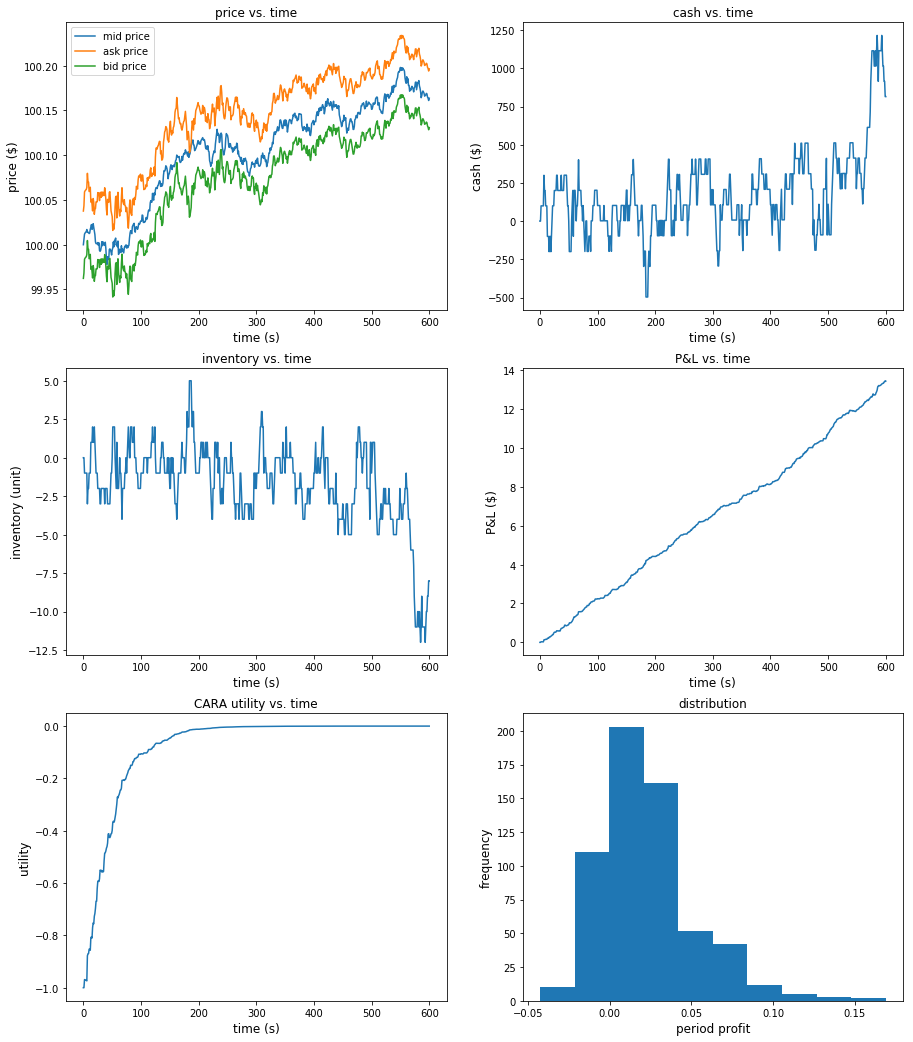

In [22]:
plt.figure(figsize = (15,18))
plt.subplot(3,2,1)
plt.plot(horizon, s, label = 'mid price')
plt.plot(horizon, s + a, label = 'ask price')
plt.plot(horizon, s - b, label = 'bid price')
plt.legend(loc = 'upper left')
plt.title('price vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('price ($)', fontsize=12)

plt.subplot(3,2,2)
plt.plot(horizon, x)
plt.title('cash vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('cash ($)', fontsize=12)

plt.subplot(3,2,3)
plt.plot(horizon, q)
plt.title('inventory vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('inventory (unit)', fontsize=12)

plt.subplot(3,2,4)
plt.plot(horizon, pol)
plt.title('P&L vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('P&L ($)', fontsize=12)

plt.subplot(3,2,5)
plt.plot(horizon, -np.exp(-gamma*pol))
plt.title('CARA utility vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('utility', fontsize=12)

plt.subplot(3,2,6)
plt.hist(dp)
plt.title('distribution', fontsize=12)
plt.xlabel('period profit', fontsize=12)
plt.ylabel('frequency', fontsize=12)


plt.show()

#### Naive trading model

In [23]:
def naive(k, A, s, q0, x0, T, N):
    
    dt = T/N
    delta_a_list = np.zeros(N+1)
    delta_b_list = np.zeros(N+1)
    q_list = np.zeros(N+1)
    x_list = np.zeros(N+1)
    q_list[0] = q0
    x_list[0] = x0
    delta_b = s[0]/1000
    delta_a = s[0]/1000
    delta_a_list[0] = delta_a
    delta_b_list[0] = delta_b
    
    for i in range(N):
        lab_a = A*np.exp(-k*delta_a)
        lab_b = A*np.exp(-k*delta_b)

        na = np.random.poisson(lam = lab_a*dt)
        nb = np.random.poisson(lam = lab_b*dt)
        
        q_list[i+1] = q_list[i] + nb - na
        x_list[i+1] = x_list[i] + (s[i] + delta_a)*na - (s[i] - delta_b)*nb
        
        delta_b = s[i+1]/1000
        delta_a = s[i+1]/1000
        
        delta_a_list[i+1] = delta_a
        delta_b_list[i+1] = delta_b
        
    pol = x_list + q_list*s
    return pol, delta_a_list, delta_b_list, q_list, x_list

In [24]:
k = 0.3*100
gamma = 0.01
sigma = 0.4*0.01
A = 0.9
q0 = 0
x0 = 0
T = 600
N = 600
s0 = 100

In [25]:
pol, a, b, q, x = naive(k, A, s, q0, x0, T, N)
psi = a + b
dp = pol[1:601] - pol[0:600]
horizon = np.array(range(N+1))*T/N

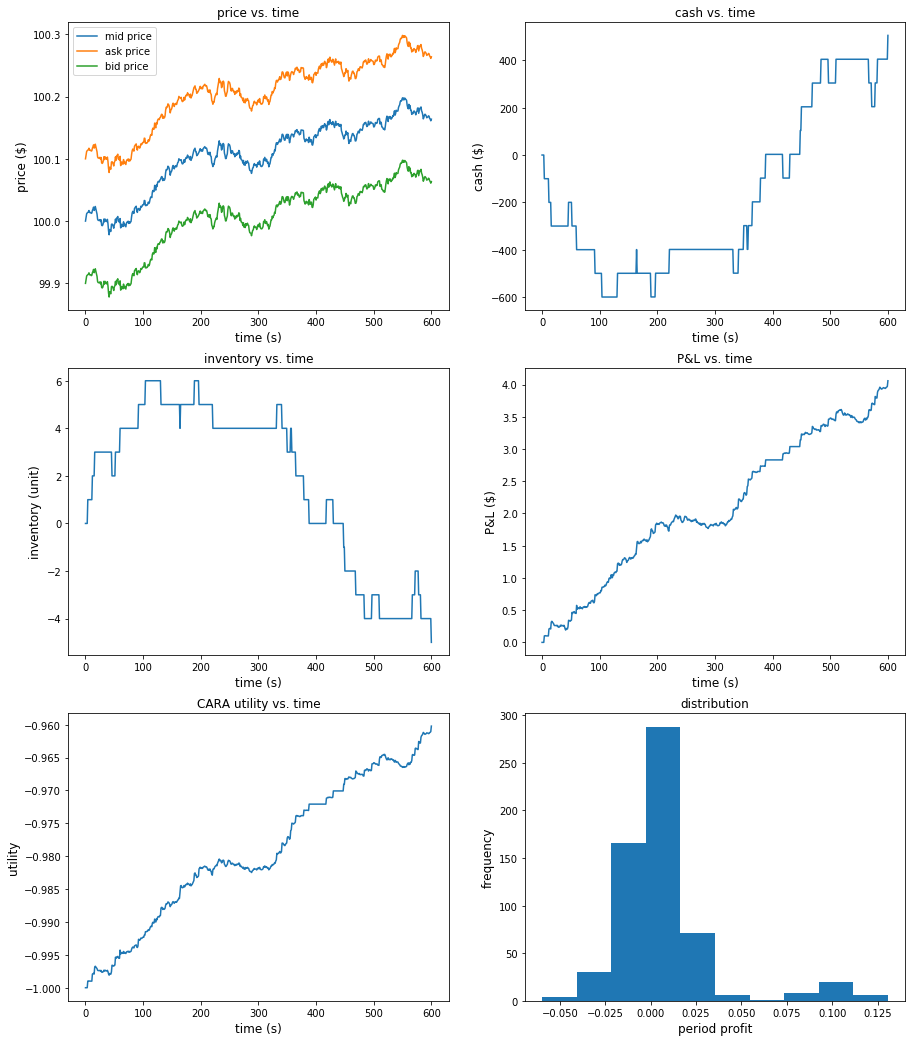

In [27]:
plt.figure(figsize = (15,18))

plt.subplot(3,2,1)
plt.plot(horizon, s, label = 'mid price')
plt.plot(horizon, s + a, label = 'ask price')
plt.plot(horizon, s - b, label = 'bid price')
plt.legend(loc = 'upper left')
plt.title('price vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('price ($)', fontsize=12)

plt.subplot(3,2,2)
plt.plot(horizon, x)
plt.title('cash vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('cash ($)', fontsize=12)

plt.subplot(3,2,3)
plt.plot(horizon, q)
plt.title('inventory vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('inventory (unit)', fontsize=12)

plt.subplot(3,2,4)
plt.plot(horizon, pol)
plt.title('P&L vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('P&L ($)', fontsize=12)

plt.subplot(3,2,5)
plt.plot(horizon, -np.exp(-gamma*pol))
plt.title('CARA utility vs. time', fontsize=12)
plt.xlabel('time (s)', fontsize=12)
plt.ylabel('utility', fontsize=12)

plt.subplot(3,2,6)
plt.hist(dp)
plt.title('distribution', fontsize=12)
plt.xlabel('period profit', fontsize=12)
plt.ylabel('frequency', fontsize=12)


plt.show()